In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from molvs import Standardizer
from molvs import standardize_smiles

### Lipophilicity
#### Dataset

In [46]:
from tdc.single_pred import ADME
data = ADME(name = 'Lipophilicity_AstraZeneca')
split = data.get_split()

Downloading...
100%|███████████████████████████████████████████████████████████████████████████████| 298k/298k [00:01<00:00, 264kiB/s]
Loading...
Done!


In [47]:
split

{'train':             Drug_ID                                               Drug     Y
 0      CHEMBL596271            Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21  3.54
 1     CHEMBL1951080  COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)... -1.18
 2        CHEMBL1771              COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1  3.69
 3      CHEMBL317462              OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2  3.14
 4     CHEMBL1940306  CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...  1.51
 ...             ...                                                ...   ...
 2935  CHEMBL1824376   O=C(Nc1cccc(O)c1)c1ccc(OCCCN2CCCC2)cc1OCc1ccccn1  1.78
 2936  CHEMBL1081772  CC(=O)N(c1ccccc1)C1CC(C)N(S(=O)(=O)c2ccccc2)c2...  3.68
 2937   CHEMBL199147  CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...  3.21
 2938    CHEMBL15932                                 COc1cccc2[nH]ncc12  2.10
 2939   CHEMBL558748                  O=C(NCC1CCCCC1)c1c(Cl)ccc2ncccc12  2.65
 
 [2940 rows x 3 columns],
 'valid':            Drug_I

In [48]:
split['train'].head()

,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


#### Standardize & calculate molecular descriptors

In [49]:
def generate(smiles):
    
    #convert the SMILES string to an rdkit molecule object & standardize:
    moldata = []
    s = Standardizer()
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(s.standardize(mol))
        
    #get set of all available molecular descriptors
    descList = []
    for desc in Descriptors.descList:
        descList.append(desc[0])
        
    #calculate molecular descriptors  
    baseData= np.arange(1,1)
    calculator = MolecularDescriptorCalculator(descList)
    i=0
    for mol in moldata:
        descriptors = calculator.CalcDescriptors(mol)
        row = np.array(list(descriptors))
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1
    
    #create dataframe
    columnNames = descList
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [33]:
#spot the difference before and after standardize
data = []
for elem in split['train'].Drug:
    data.append(standardize_smiles(elem))
    
i = 0
j = 0
flag = False
while(i<len(split['train'].Drug) and j<len(split['train'].Drug)):
    if data[i] != split['train'].Drug[j]:
        flag = True
        break
    i+=1
    j+=1
print(flag)

False


In [9]:
df = generate(split['train'].Drug)

In [10]:
df = pd.concat([df ,split['train'].Y], axis=1)
df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,178.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,10.840078,-0.824800,10.840078,0.336659,0.818112,303.405,282.237,303.162314,116.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.14
4,11.506276,-3.216307,11.506276,0.260320,0.806971,397.496,374.312,397.134779,146.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,12.941497,-0.335922,12.941497,0.080652,0.445929,447.535,418.303,447.215806,172.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.78
2936,13.486145,-3.728750,13.486145,0.076324,0.610975,420.534,396.342,420.150764,154.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.68
2937,13.543113,-3.267070,13.543113,0.034005,0.334738,554.703,518.415,554.241470,208.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.21
2938,5.125787,0.857639,5.125787,0.857639,0.666148,148.165,140.101,148.063663,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.10


In [11]:
df.shape

(2940, 209)

##### Missing values

In [14]:
df.isnull().sum()

MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Y                    0
Length: 209, dtype: int64

In [15]:
#Columns names, with having at least 1 null value
df.columns[df.isnull().any()]

Index(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW'],
      dtype='object')

In [16]:
# Columns with count, with having at least 1 null value.
df[df.columns[df.isnull().any()]].isnull().sum()

MaxPartialCharge       1
MinPartialCharge       1
MaxAbsPartialCharge    1
MinAbsPartialCharge    1
BCUT2D_MWHI            1
BCUT2D_MWLOW           1
BCUT2D_CHGHI           1
BCUT2D_CHGLO           1
BCUT2D_LOGPHI          1
BCUT2D_LOGPLOW         1
BCUT2D_MRHI            1
BCUT2D_MRLOW           1
dtype: int64

In [17]:
df[df.isna().any(axis=1)]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
1070,12.138731,0.078403,12.138731,0.078403,0.622431,274.181,265.109,274.984935,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.31


In [18]:
#Drop Missing Values
df = df.dropna()
df.shape

(2939, 209)

In [19]:
X_train, Y_train = df.iloc[:, :-1], df.iloc[:,-1]

#### Baseline model
#### Optimizing Hyperparameters

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [21]:
#number of trees
n_estimators = [200, 500, 800, 1500, 2500, 5000]
# maw number of levels in a tree
max_depth = [10, 20, 30, 40, 50]
# max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15]

grid_param = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

rfr = RandomForestRegressor(random_state=1)
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = grid_param, n_iter = 200, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

In [34]:
rfr_random.fit(X_train, Y_train)
print(rfr_random.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 84.9min finished


{'n_estimators': 5000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}


#### Model (descriptors only)

In [23]:
rfr = RandomForestRegressor(n_estimators = 5000, max_depth = 50, max_features = 'auto', min_samples_split = 2, min_samples_leaf = 1)
rfr.fit(X_train, Y_train)

RandomForestRegressor(max_depth=50, n_estimators=5000)

#### Results

In [24]:
df_val = generate(split['valid'].Drug)

In [25]:
df_val[df_val.isna().any(axis=1)]

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [30]:
X_val, Y_val = df_val, split['valid'].Y

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
Y_pred_val = rfr.predict(X_val)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_val, Y_pred_val))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_val, Y_pred_val))

Mean squared error (MSE): 0.46
Coefficient of determination (R^2): 0.68


#### Scatter plot of actual vs. predicted Y

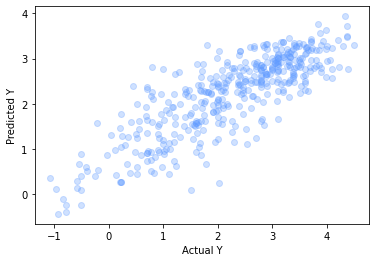

In [46]:
plt.scatter(x=Y_val, y=Y_pred_val, c="#619CFF", alpha=0.3)

plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.show()

#### With fingerprints
#### Generate Molecular Fingerprints

In [2]:
def generate_fingerprints(smiles):
    fps = np.zeros((1, 2048))
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        row = np.array([int(x) for x in fp.ToBitString()])
        fps = np.row_stack((fps, row))
    fps = np.delete(fps, 0, axis=0)
    return fps 

In [64]:
fps = generate_fingerprints(split['train'].Drug)

In [65]:
fps.shape

(2940, 2048)

In [66]:
fps

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

####  Models comparison

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

LR: 2.900547
RFR: 0.693769
DTR: 1.286351
SVM: 0.621714


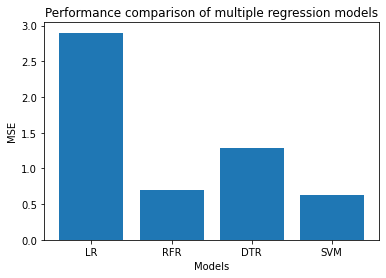

In [53]:
models = [
          ('LR', LinearRegression()), 
          ('RFR', RandomForestRegressor()),
          ('DTR', DecisionTreeRegressor()),
          ('SVM', SVR())
        ]

results = []
names = []

for name, model in models:
    clf = model.fit(generate_fingerprints(split['train'].Drug), split['train'].Y)
    y_pred = clf.predict(generate_fingerprints(split['test'].Drug))
    mse=metrics.mean_squared_error(y_pred, split['test'].Y)
    print("%s: %f" % (name, mse))
    results.append(mse)
    names.append(name)
    
plt.bar(names, results)
plt.xlabel("Models")
plt.ylabel("MSE")
plt.title("Performance comparison of multiple regression models")
plt.show()

### Ames mutagenicity
#### Dataset

In [3]:
from tdc.single_pred import Tox
data = Tox(name = 'AMES')
split_AMES = data.get_split()

Found local copy...
Loading...
Done!


In [4]:
split_AMES

{'train':         Drug_ID                                               Drug  Y
 0        Drug 1       O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2  1
 1        Drug 2  O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...  0
 2        Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1
 3        Drug 4                          [N-]=[N+]=C1C=NC(=O)NC1=O  1
 4        Drug 6          CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O  1
 ...         ...                                                ... ..
 5089  Drug 7568  CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C  0
 5090  Drug 7587                                   CCCCCCCCCCCCOCCO  0
 5091  Drug 7593                              CCOP(=S)(CC)Sc1ccccc1  0
 5092  Drug 7598                        C=C(C)C1CC=C(C)C(OC(C)=O)C1  0
 5093  Drug 7602  CC/N=c1\cc2oc3cc(NCC)c(C)cc3c(-c3ccccc3C(=O)OC...  0
 
 [5094 rows x 3 columns],
 'valid':        Drug_ID                                               Drug  Y
 0    Drug 4852  C=C(C)C(=O)OCC(

In [5]:
split_AMES['train'].head()

,Drug_ID,Drug,Y
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1


In [6]:
fps = generate_fingerprints(split_AMES['train'].Drug)
fps

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
df_AMES = pd.concat([pd.DataFrame(data=fps), split_AMES['train'].Y], axis=1)
df_AMES

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


#### Are the classes balanced?

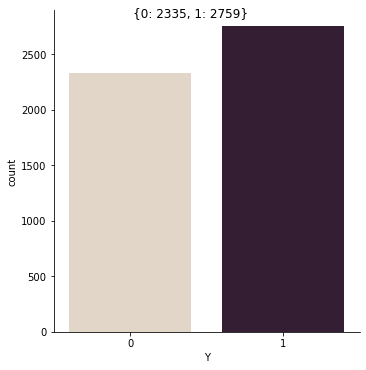

In [13]:
#store Y of all compounds
y = df_AMES.Y.values

#return the count for each unique value (0 and 1)
unique, counts = np.unique(y, return_counts=True)

#plot the label counts 
balanced = sns.catplot(x="Y", kind="count", palette="ch:.25", data=df_AMES)

balanced.fig.suptitle(dict(zip(unique, counts)))
plt.show()

In [18]:
# split train data
X_train_AMES, Y_train_AMES = df_AMES.iloc[:, :-1], df_AMES.iloc[:,-1]

####  Models comparison

In [32]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

LR: 0.782105 (0.026071)
RF: 0.813317 (0.026581)
KNN: 0.777001 (0.016676)
SVM: 0.815669 (0.019312)


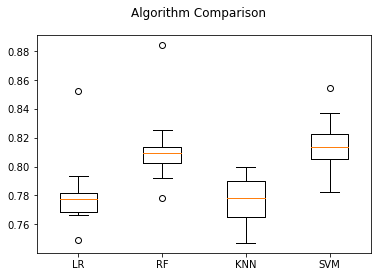

In [45]:
models = [
          ('LR', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC())
        ]
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_train_AMES, Y_train_AMES, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Final model, metrics and prediction

0.8337912087912088


Text(0.5, 1.0, 'Accuracy Score: 0.8337912087912088')

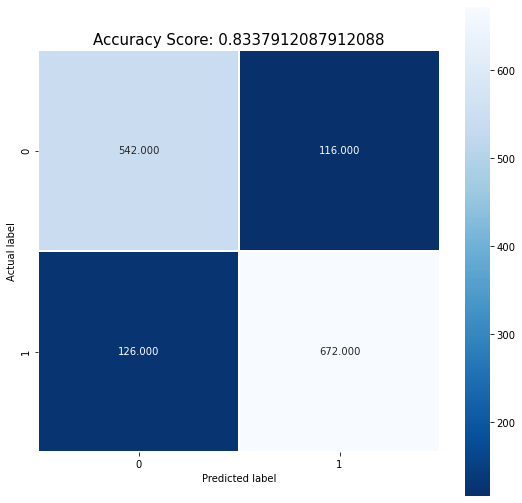

In [33]:
#fit the training data
rf_fit = RandomForestClassifier().fit(X_train_AMES, Y_train_AMES)

#evaluate accuracy using the test set 
accuracy = rf_fit.score(generate_fingerprints(split_AMES['test'].Drug), split_AMES['test'].Y)
print(accuracy)


#predicting using the test set and creating a confusion matrix
predictions = rf_fit.predict(generate_fingerprints(split_AMES['test'].Drug))
cm = metrics.confusion_matrix(split_AMES['test'].Y, predictions)

# heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(title, size = 15)